# ANN Models of Cell Viability

In [1]:
import inspect
import numpy as np
import pandas as pd
import csv
import sklearn
import time
import seaborn as sb
import matplotlib.pyplot as plt

# Listing version of all modules:
for n in dir():
    if inspect.ismodule(eval(n)):
        if '__version__' in dir(eval(n)):
            print(f"{eval(f'{n}.__name__')}: {eval(f'{n}.__version__')}")
        elif '_version_' in dir(eval(n)):
            print(f"{eval(f'{n}.__name__')}: {eval(f'{n}._version_')}")

csv: 1.0
numpy: 1.26.2
pandas: 1.5.3
seaborn: 0.12.2
sklearn: 1.3.2


In [2]:
# Auxiliary Functions

def make_fitness_plot(model, x_train, y_train, x_test, y_test, y_name='Property', ax=None):
  y_train_pred = model.predict(x_train)
  y_test_pred = model.predict(x_test)
  if not ax:
    fig, ax = plt.subplots()
  l_train = ax.scatter(y_train,y_train_pred)
  l_test = ax.scatter(y_test,y_test_pred)
  y_full=np.concatenate((y_test,y_train))
  l3 = ax.plot(y_full,y_full)
  ax.set_xlabel(f"{y_name} (Original)")
  ax.set_ylabel(f"{y_name} (Predicted)")
  l = ax.legend([l_train,l_test],['Train data','Validation data'])

def make_residual_plot(model, x_train, y_train, x_test, y_test, y_name='Property', ax=None):
  y_train_pred = model.predict(x_train)
  y_test_pred = model.predict(x_test)
  if not ax:
    fig, ax = plt.subplots()
  l_train = ax.scatter(y_train,y_train_pred-y_train)
  l_test = ax.scatter(y_test,y_test_pred-y_test)
  y_full=np.concatenate((y_test,y_train))
  l3 = ax.hlines(0, 0, 1, transform=ax.get_yaxis_transform(), colors='black')
  ax.set_xlabel(f"{y_name} (Original)")
  ax.set_ylabel(f"Residuals")
  l = ax.legend([l_train,l_test],['Train data','Validation data'])

## Loading data

In [1]:
data = pd.read_excel("221123-raquel_data_expanded.xlsx")
# Creating subsets for solid and liquid phase combinations
s_data=data.loc[((data['AgY']>0) | (data['Ag(5-FU)@Y']>0) | (data['5-FU@Y'] > 0))]
l_data=data.loc[((data['Ag_l']>0) | (data['FU_l']>0))]

target = "Cell_viab"
s_features = ['AgY' ,'Ag(5-FU)@Y','5-FU@Y']
l_features = ['Ag_l','FU_l']
print(len(s_data))
print(len(l_data))

NameError: name 'pd' is not defined

## Preliminary Data Analysis

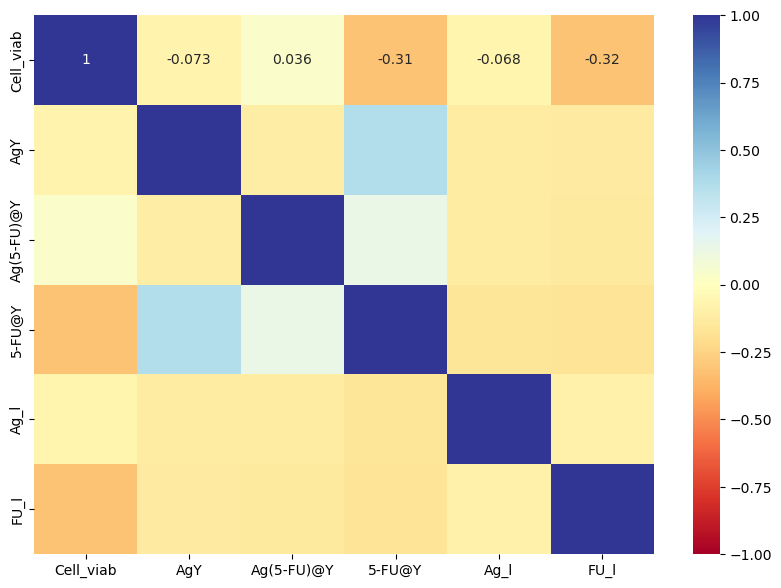

In [4]:
all_vars = [target] + s_features + l_features
fig,ax = plt.subplots(1,1,figsize=(10,7))
dataplot = sb.heatmap(data[all_vars].corr(), vmin=-1.0, vmax=1.0, cmap="RdYlBu", annot=True, ax=ax)
plt.show()

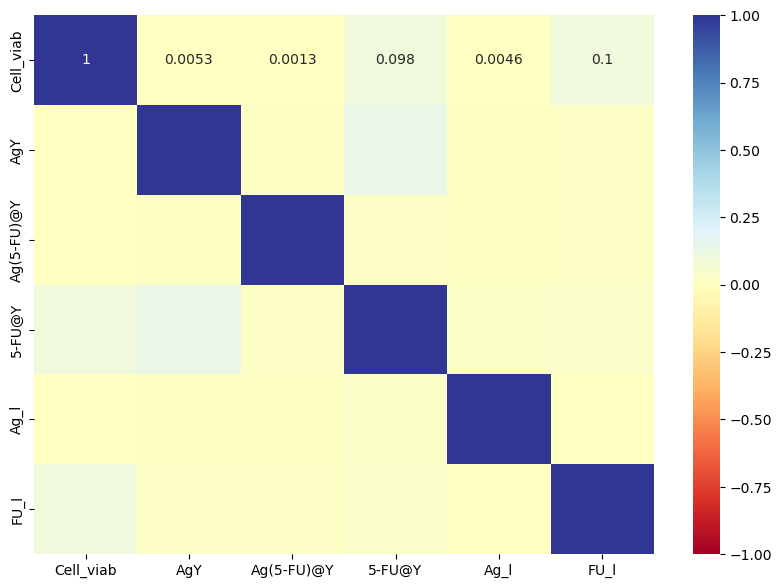

In [5]:
all_vars = [target] + s_features + l_features
fig,ax = plt.subplots(1,1,figsize=(10,7))
dataplot = sb.heatmap(data[all_vars].corr()**2, vmin=-1.0, vmax=1.0, cmap="RdYlBu", annot=True, ax=ax)
plt.show()

## Plots from the CV optimization of the ANN topology

Previous calculations using a systematic CV grid search of the strength of the L2 regularization term ($\alpha$) degree of the polynomial featurazation and number of neurons in the hidden layer of the MLP regressor, resulted in the following optimised hyper-paramters:
* Featurization degree: 2
* $\alpha$    : 0.001
* $N_\mathrm{hidden}$: (50,)

(0.0, 1.0)

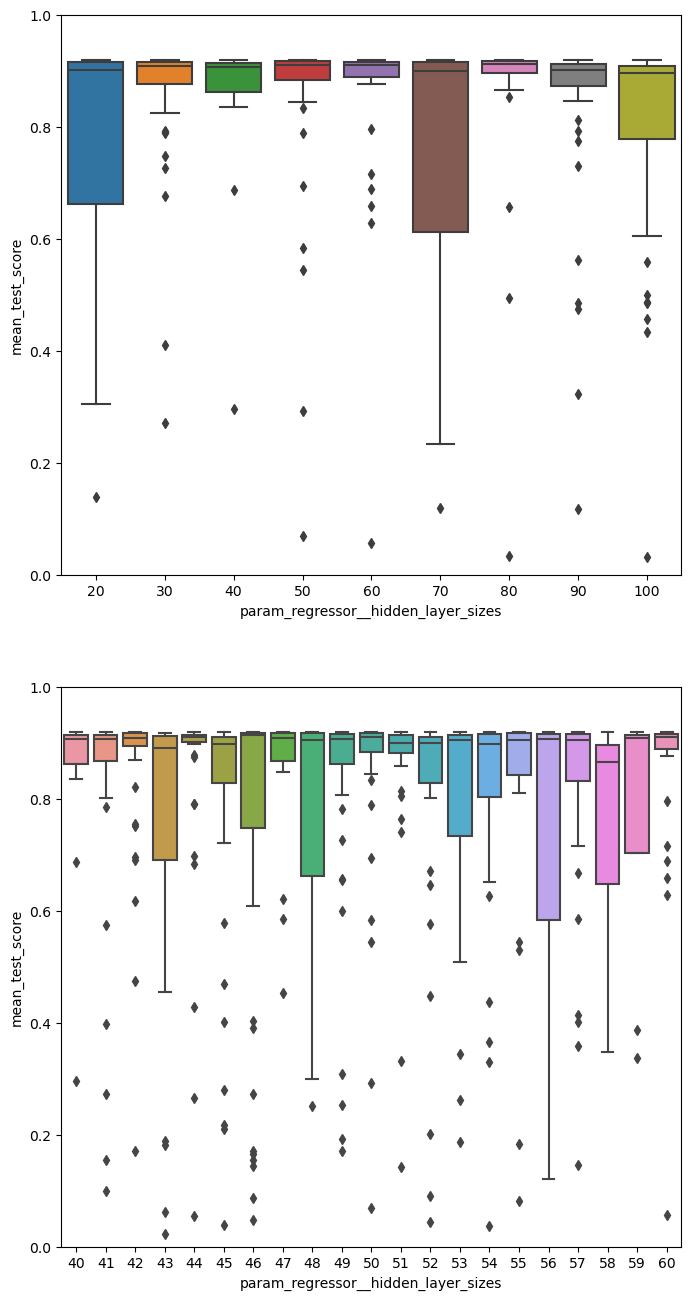

In [6]:
cv_data1 = pd.read_excel("221123-ANN_opt-cv_data.xlsx")
cv_data2 = pd.read_excel("221123-ANN_opt-cv_data_fine_tune.xlsx")

_, axs = plt.subplots(nrows=2, figsize=(8,16))
sb.boxplot(x='param_regressor__hidden_layer_sizes', y='mean_test_score', data=cv_data1, ax=axs[0])
axs[0].set_ylim(0,1)
sb.boxplot(x='param_regressor__hidden_layer_sizes', y='mean_test_score', data=cv_data2, ax=axs[1])
axs[1].set_ylim(0,1)


## Multilayer Perceptron Regressor Model for Liquid Preparations

Score (train) = 0.9900
Score (test)  = 0.9712
Time to train = 0.8 s


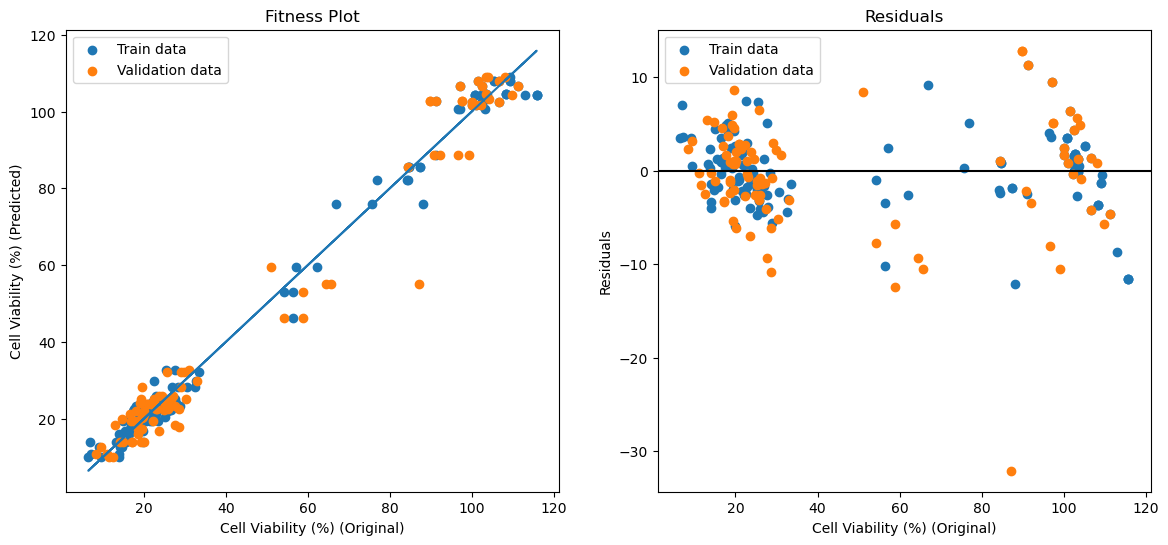

In [7]:
from sklearn import model_selection
from sklearn import pipeline
from sklearn import neural_network
from sklearn import compose
from sklearn import preprocessing

train_set, val_set = model_selection.train_test_split(l_data,train_size=0.6,random_state=42)

X_train = train_set[l_features]
Y_train = train_set[target]
X_val = val_set[l_features]
Y_val = val_set[target]

l_X_train = X_train
l_Y_train = Y_train
l_X_val = X_val
l_Y_val = Y_val

num_pross = pipeline.Pipeline(steps=[('scale',preprocessing.StandardScaler()),
                                     ('featurize',preprocessing.PolynomialFeatures(degree=2))])

pre_transformer = compose.ColumnTransformer([
                  ('numerical',num_pross,compose.make_column_selector(dtype_include=np.number),                  )
                   ], remainder='passthrough')

reg = neural_network.MLPRegressor(hidden_layer_sizes=(50,), solver='lbfgs', alpha=0.001,  max_iter=10_000, random_state=42)

l_model = pipeline.Pipeline(steps=[('prepare',pre_transformer),
                                   ('regressor',reg)])

start=time.time()
l_model.fit(X_train,Y_train)
end=time.time()

print(f"Score (train) = {l_model.score(X_train,Y_train):6.4f}")
print(f"Score (test)  = {l_model.score(X_val,Y_val):6.4f}")
print(f"Time to train = {end-start:0.1f} s")

fig, axs = plt.subplots(1,2,figsize=(14,6))
axs[0].set_title("Fitness Plot")
make_fitness_plot(l_model,X_train,Y_train,X_val,Y_val,'Cell Viability (%)',ax=axs[0])
axs[1].set_title("Residuals")
make_residual_plot(l_model,X_train,Y_train,X_val,Y_val,'Cell Viability (%)',ax=axs[1])
plt.show()

In [8]:
from sklearn import inspection

PI = inspection.permutation_importance(l_model,l_data[l_features],l_data[target], random_state=42)
pi_data = pd.DataFrame({
    'Feature':l_features,
    'PI_average':PI['importances_mean'],
    'PI_std':PI['importances_std']
    })
print(pi_data)

  Feature  PI_average     PI_std
0    Ag_l    5.314540   9.079646
1    FU_l   12.992294  20.772582


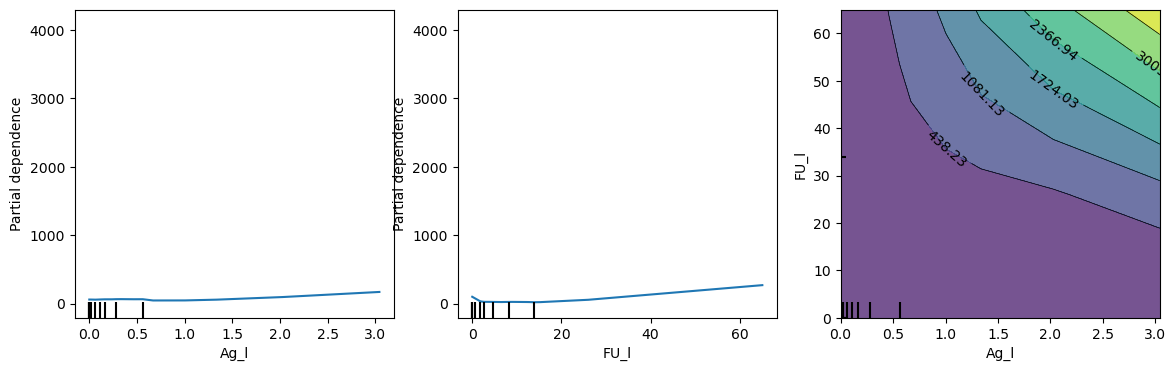

In [9]:
fig, ax = plt.subplots(ncols=3,nrows=1,figsize=(14,4))

display = inspection.PartialDependenceDisplay.from_estimator(l_model, l_data[l_features], 
                                                             features=['Ag_l','FU_l',('Ag_l','FU_l')],
                                                             kind='average',
                                                             response_method='auto',
                                                             grid_resolution=200,
                                                             ax=ax)

plt.show()

## Multilayer Perceptron Regressor Model for Zeolite-base Preparations

Score (train) = 0.9425
Score (test)  = 0.8971
Time to train = 0.4 s


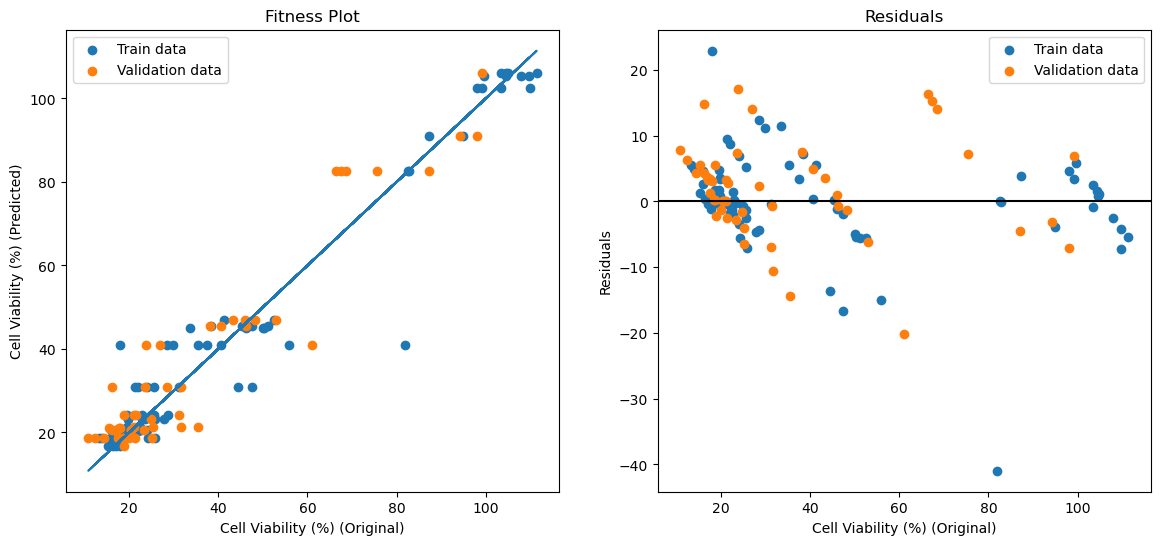

In [10]:
from sklearn import model_selection
from sklearn import pipeline
from sklearn import neural_network
from sklearn import compose
from sklearn import preprocessing

train_set, val_set = model_selection.train_test_split(s_data,train_size=0.6,random_state=42)

X_train = train_set[s_features]
Y_train = train_set[target]
X_val = val_set[s_features]
Y_val = val_set[target]

s_X_train = X_train
s_Y_train = Y_train
s_X_val = X_val
s_Y_val = Y_val

num_pross = pipeline.Pipeline(steps=[('scale',preprocessing.StandardScaler()),
                                     ('featurize',preprocessing.PolynomialFeatures(degree=2))])

pre_transformer = compose.ColumnTransformer([
                  ('numerical',num_pross,compose.make_column_selector(dtype_include=np.number),                  )
                   ], remainder='passthrough')

reg = neural_network.MLPRegressor(hidden_layer_sizes=(50,), solver='lbfgs', alpha=0.001,  max_iter=10_000, random_state=42)

s_model = pipeline.Pipeline(steps=[('prepare',pre_transformer),
                                   ('regressor',reg)])

start=time.time()
s_model.fit(X_train,Y_train)
end=time.time()

print(f"Score (train) = {s_model.score(X_train,Y_train):6.4f}")
print(f"Score (test)  = {s_model.score(X_val,Y_val):6.4f}")
print(f"Time to train = {end-start:0.1f} s")

fig, axs = plt.subplots(1,2,figsize=(14,6))
axs[0].set_title("Fitness Plot")
make_fitness_plot(s_model,X_train,Y_train,X_val,Y_val,'Cell Viability (%)',ax=axs[0])
axs[1].set_title("Residuals")
make_residual_plot(s_model,X_train,Y_train,X_val,Y_val,'Cell Viability (%)',ax=axs[1])
plt.show()

In [11]:
from sklearn import inspection

PI = inspection.permutation_importance(s_model,s_data[s_features],s_data[target], random_state=42)
pi_data = pd.DataFrame({
    'Feature':s_features,
    'PI_average':PI['importances_mean'],
    'PI_std':PI['importances_std']
    })
print(pi_data)

      Feature  PI_average    PI_std
0         AgY    0.944198  0.107481
1  Ag(5-FU)@Y    0.799607  0.187256
2      5-FU@Y    3.903426  0.735129


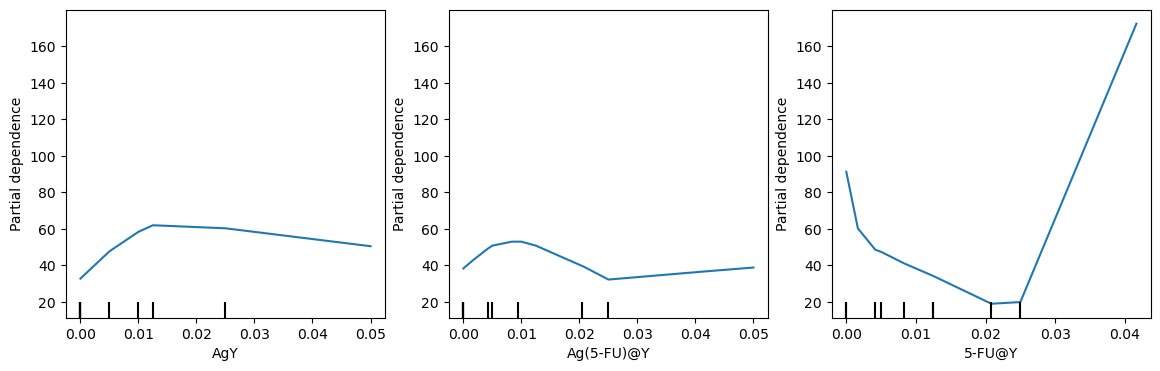

In [12]:
fig, ax = plt.subplots(ncols=3,nrows=1,figsize=(14,4))

display = inspection.PartialDependenceDisplay.from_estimator(s_model, s_data[s_features], 
                                                             features=['AgY','Ag(5-FU)@Y','5-FU@Y'],
                                                             kind='average',
                                                             response_method='auto',
                                                             grid_resolution=200,
                                                             ax=ax)

plt.show()

## Dose-Response Curves from MLPr model

In [13]:
from scipy import optimize

def dr_curve(dose, E_max, EC50, n):
    return E_max/(1+((EC50/dose)**n))

def idr_curve(effect, E_max, EC50, n):
    return EC50/(E_max/effect-1)**(1/n)

Dose (µg/mL)  Fraction Affected  
    0.36         0.0131       
    0.46         0.1800       
    0.56         0.1444       
    0.67         0.4395       
    0.77         0.6037       
    0.87         0.6488       
    0.97         0.7001       
    1.07         0.7506       
    1.17         0.7901       
    1.27         0.8330       
    1.38         0.9039       
    1.48         1.0272       
    1.58         1.0426       
    1.68         1.0191       
    1.78         0.9892       
    1.89         0.9532       
    1.99         0.9109       
    2.09         0.8623       
    2.19         0.8075       
    2.29         0.7557       
    2.39         0.7443       
    2.50         0.7329       
    2.60         0.7216       
    2.70         0.7103       
    2.80         0.7179       
Dose-Response Parameters for Ag(l): n= 5.6667, D50= 0.6778 µg/mL, EC_Max= 0.8549


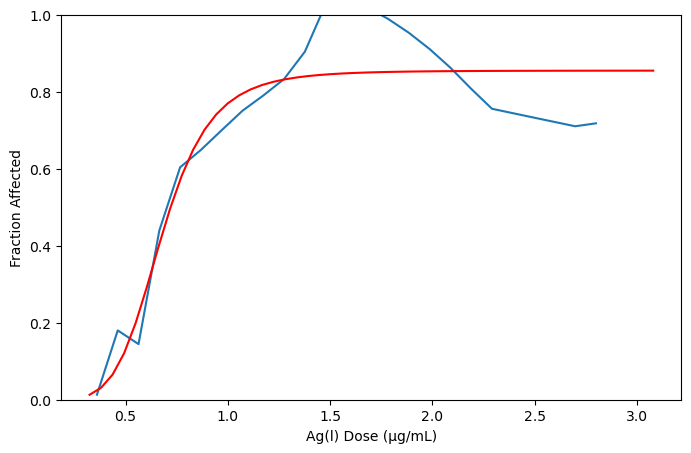

In [14]:
# Dose - Response Curve for Ag_l

npoints=25
dose_min=0.36
dose_max=2.8
dose=np.linspace(dose_min,dose_max,npoints)

X_data = pd.DataFrame({'Ag_l':dose,
                       'FU_l':np.zeros(npoints)})
fraction_afected = 1.0-(l_model.predict(X_data)/100.0)

print(f"Dose (µg/mL) {'Fraction Affected':^20s}")
for i, d in enumerate(dose):
    print(f"{d:8.2f}  {fraction_afected[i]:^20.4f}")


#y = np.log10(fraction_afected/(1.0-fraction_afected))
#x = np.log10(dose)
#A = np.vstack([x,np.ones(len(x))]).T
#m, mld50 = np.linalg.lstsq(A, y, rcond=None)[0]
#d50 = 10**(-mld50/m)
    
opt = optimize.curve_fit(dr_curve,dose,fraction_afected,bounds=(0,np.inf))

E_max_Agl, EC50_Agl, n_Agl =opt[0]

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(dose,fraction_afected)
plt.plot(np.linspace(0.9*dose_min,1.1*dose_max,npoints*2),dr_curve(np.linspace(0.9*dose_min,1.1*dose_max,npoints*2),E_max_Agl,EC50_Agl,n_Agl),c="red")
#plt.plot(dose,m*np.log10(dose)-(m*np.log10(d50)),c="green")
ax.set_xlabel("Ag(l) Dose (µg/mL)")
ax.set_ylabel("Fraction Affected")
ax.set_ylim(0,1)

print(f"Dose-Response Parameters for Ag(l): n= {n_Agl:6.4f}, D50= {EC50_Agl:6.4f} µg/mL, EC_Max= {E_max_Agl:6.4f}")

Dose (µg/mL)  Fraction Affected  
    0.30         0.0150       
    0.56         0.1299       
    0.82         0.2463       
    1.08         0.3642       
    1.33         0.4855       
    1.59         0.6203       
    1.85         0.7032       
    2.11         0.7192       
    2.37         0.7431       
    2.62         0.7644       
    2.88         0.7853       
    3.14         0.7849       
    3.40         0.7664       
    3.66         0.7575       
    3.92         0.7660       
    4.18         0.7750       
    4.43         0.7844       
    4.69         0.7942       
    4.95         0.8045       
    5.21         0.8151       
    5.47         0.8263       
    5.73         0.8345       
    5.98         0.8321       
    6.24         0.8271       
    6.50         0.8225       
Dose-Response Parameters for 5-FU(l): n= 2.8719, D50= 1.1087 µg/mL, EC_Max= 0.8190


/tmp/ipykernel_53530/2656640208.py:4: RuntimeWarning: divide by zero encountered in divide
  return E_max/(1+((EC50/dose)**n))


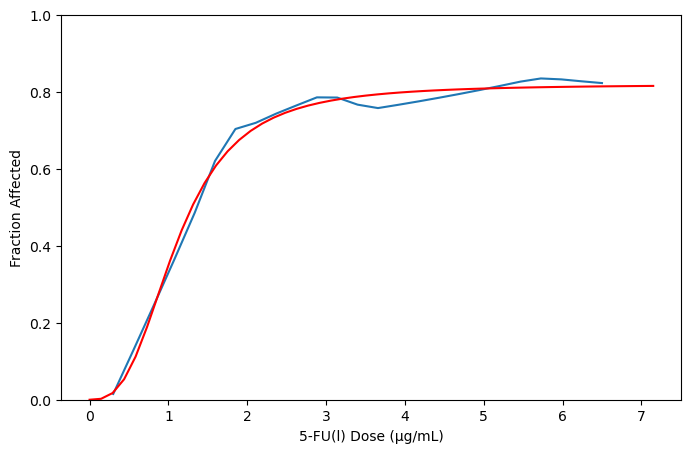

In [15]:
# Dose - Response Curve for 5-FU (l)

npoints=25
dose_min=0.3 #data['FU_l'].min()
dose_max=6.5 #data['FU_l'].max()
dose=np.linspace(dose_min,dose_max,npoints)

X_data = pd.DataFrame({'FU_l':dose,
                       'Ag_l':np.zeros(npoints)})
fraction_afected = 1.0-(l_model.predict(X_data)/100.0)

print(f"Dose (µg/mL) {'Fraction Affected':^20s}")
for i, d in enumerate(dose):
    print(f"{d:8.2f}  {fraction_afected[i]:^20.4f}")

opt = optimize.curve_fit(dr_curve,dose,fraction_afected,bounds=(0,np.inf))

E_max_FUl, EC50_FUl, n_FUl =opt[0]

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(dose,fraction_afected)
plt.plot(np.linspace(0,1.1*dose_max,npoints*2),dr_curve(np.linspace(0,1.1*dose_max,npoints*2),E_max_FUl,EC50_FUl,n_FUl),c="red")
ax.set_xlabel("5-FU(l) Dose (µg/mL)")
ax.set_ylabel("Fraction Affected")
ax.set_ylim(0,1)

print(f"Dose-Response Parameters for 5-FU(l): n= {n_FUl:6.4f}, D50= {EC50_FUl:6.4f} µg/mL, EC_Max= {E_max_FUl:6.4f}")

/tmp/ipykernel_53530/2656640208.py:7: RuntimeWarning: invalid value encountered in scalar power
  return EC50/(E_max/effect-1)**(1/n)
/tmp/ipykernel_53530/2656640208.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  return EC50/(E_max/effect-1)**(1/n)


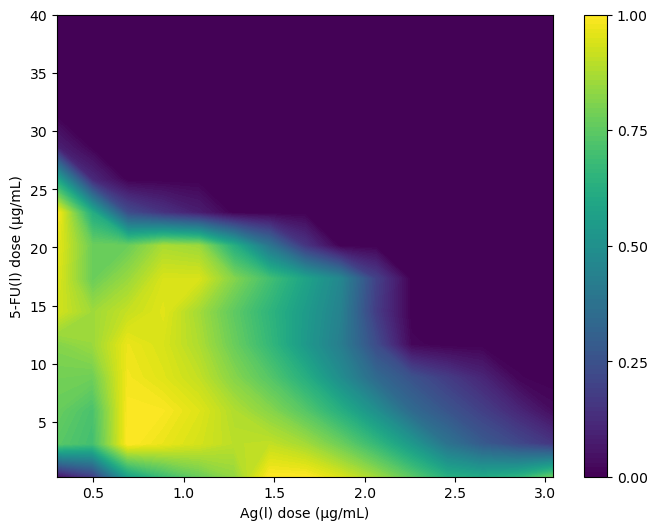

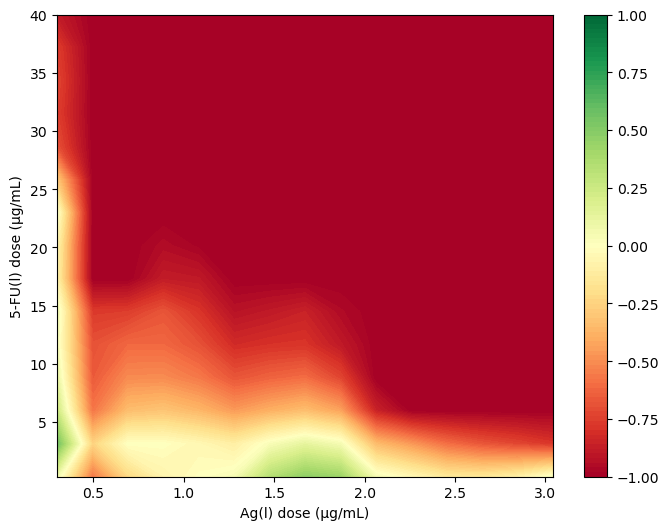

In [16]:
# bi-dimensional Dose-Response curve for Ag(l) and 5-FU(l)
npoints = 15
ag_min=0.3
ag_max=data['Ag_l'].max()
fu_min=0.3
fu_max=40.0 #data['FU_l'].max()
dose_ag = np.linspace(ag_min,ag_max,npoints)
dose_fu = np.linspace(fu_min,fu_max,npoints)

X_data = pd.DataFrame({'Ag_l':dose_ag,
                       'FU_l':np.zeros(npoints)})
fraction_afected_ag = 1.0-(l_model.predict(X_data)/100.0)

X_data = pd.DataFrame({'Ag_l':np.zeros(npoints),
                       'FU_l':dose_fu})
fraction_afected_fu = 1.0-(l_model.predict(X_data)/100.0)


X_d={'Ag_l':list(),'FU_l':list()}
for i in dose_ag:
    for j in dose_fu:
        X_d['Ag_l'].append(i)
        X_d['FU_l'].append(j)

response = 1.0-(l_model.predict(pd.DataFrame(X_d))/100.0)


z=np.zeros((npoints,npoints))
diff = np.zeros((npoints,npoints))
CI = np.zeros((npoints,npoints))

for i,d_agl in enumerate(dose_ag):
    for j,d_5ful in enumerate(dose_fu):
        z[i,j]=response[i+(npoints*j)]
        if z[i,j]<0.0: z[i,j]=0.0
        if z[i,j]>1.0: z[i,j]=1.0
        frac_ag=d_agl/(d_agl+d_5ful)
        frac_fu=d_5ful/(d_agl+d_5ful)
        eq_agl = idr_curve(frac_ag*z[i,j],E_max_Agl,EC50_Agl,n_Agl)
        eq_5ful = idr_curve(frac_fu*z[i,j],E_max_FUl,EC50_FUl,n_FUl)
        diff[i,j] = z[i,j] - (fraction_afected_ag[i]+fraction_afected_fu[j])

diff[diff>1.0]=1.0
diff[diff< -1.0]=-1.0

fig, ax = plt.subplots(figsize=(8,6))
cp = ax.contourf(dose_ag,dose_fu,z, levels=np.linspace(0.0,1.0,100))
ax.set_ylim(fu_min,fu_max)
ax.set_xlim(ag_min,ag_max)
cb = fig.colorbar(cp)
cb.set_ticks([0.0,0.25,0.5,0.75,1.0])
ax.set_xlabel("Ag(l) dose (µg/mL)")
ax.set_ylabel("5-FU(l) dose (µg/mL)")
plt.show()

fig, ax = plt.subplots(figsize=(8,6))
cp = ax.contourf(dose_ag,dose_fu,diff, levels=np.linspace(-1.0,1.0,100), cmap="RdYlGn")
ax.set_ylim(fu_min,fu_max)
ax.set_xlim(ag_min,ag_max)
cb = fig.colorbar(cp)
cb.set_ticks([-1.0,-0.75,-0.5,-0.25,0.0,0.25,0.5,0.75,1.0])
ax.set_xlabel("Ag(l) dose (µg/mL)")
ax.set_ylabel("5-FU(l) dose (µg/mL)")
plt.show()


Dose (µg/mL)  Fraction Affected  
    0.01        -0.0547       
    0.01        -0.0742       
    0.01        -0.0737       
    0.01        -0.0526       
    0.02        -0.0065       
    0.02         0.0271       
    0.02         0.0239       
    0.02         0.0338       
    0.02         0.0568       
    0.03         0.0888       
    0.03         0.1306       
    0.03         0.1844       
    0.03         0.2460       
    0.03         0.3058       
    0.03         0.3365       
    0.04         0.3737       
    0.04         0.3939       
    0.04         0.4081       
    0.04         0.4256       
    0.04         0.4464       
    0.04         0.4710       
    0.05         0.4966       
    0.05         0.5138       
    0.05         0.5335       
    0.05         0.5499       
Dose-Response Parameters for AgY: n= 6.6281, D50= 0.0314 µg/mL, EC_Max= 0.5438


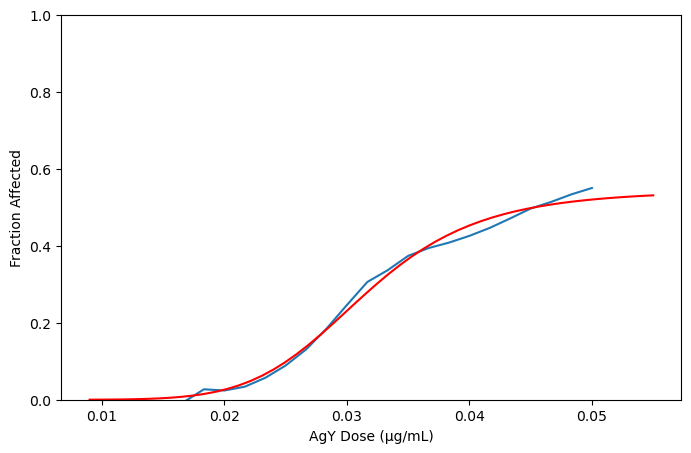

In [17]:
# Dose - Response Curve for AgY

npoints=25
dose_min=0.01
dose_max=data['AgY'].max()
dose=np.linspace(dose_min,dose_max,npoints)

X_data = pd.DataFrame({'AgY':dose,
                       '5-FU@Y':np.zeros(npoints),
                       'Ag(5-FU)@Y':np.zeros(npoints)})
fraction_afected = 1.0-(s_model.predict(X_data)/100.0)

print(f"Dose (µg/mL) {'Fraction Affected':^20s}")
for i, d in enumerate(dose):
    print(f"{d:8.2f}  {fraction_afected[i]:^20.4f}")

opt = optimize.curve_fit(dr_curve,dose,fraction_afected,bounds=(0,np.inf))

E_max_AgY, EC50_AgY, n_AgY =opt[0]

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(dose,fraction_afected)
plt.plot(np.linspace(0.9*dose_min,1.1*dose_max,npoints*2),dr_curve(np.linspace(0.9*dose_min,1.1*dose_max,npoints*2),E_max_AgY,EC50_AgY,n_AgY),c="red")
ax.set_xlabel("AgY Dose (µg/mL)")
ax.set_ylabel("Fraction Affected")
ax.set_ylim(0,1)

print(f"Dose-Response Parameters for AgY: n= {n_AgY:6.4f}, D50= {EC50_AgY:6.4f} µg/mL, EC_Max= {E_max_AgY:6.4f}")

Dose (µg/mL)  Fraction Affected  
  0.0001         0.4346       
  0.0017         0.6227       
  0.0032         0.7133       
  0.0048         0.7557       
  0.0064         0.8041       
  0.0080         0.8105       
  0.0095         0.8220       
  0.0111         0.8329       
  0.0127         0.8524       
  0.0143         0.8808       
  0.0158         0.9115       
  0.0174         0.9478       
  0.0190         0.9930       
  0.0206         1.0405       
  0.0221         1.0691       
  0.0237         1.0954       
  0.0253         1.0931       
  0.0269         1.0914       
  0.0284         1.0910       
  0.0300         1.0919       
Dose-Response Parameters for 5-FU@Y: n= 0.6452, D50= 0.0003 µg/mL, EC_Max= 1.0000


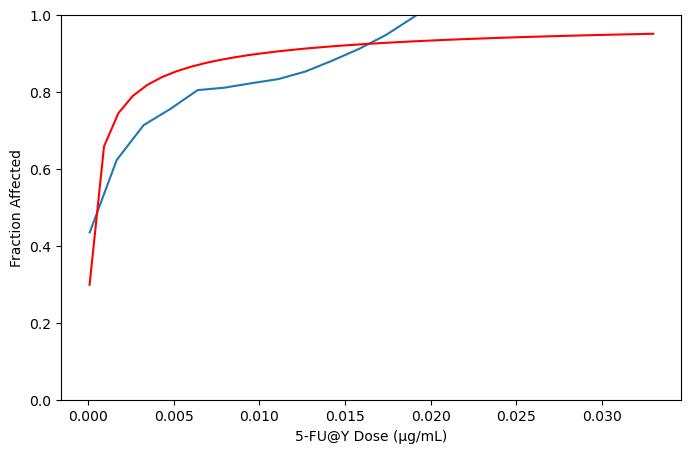

In [18]:
# Dose - Response Curve for 5-FU@Y

npoints=20
dose_min=0.0001#data['5-FU@Y'].min()
dose_max=0.030#data['5-FU@Y'].max()
dose=np.linspace(dose_min,dose_max,npoints)

X_data = pd.DataFrame({'AgY':np.zeros(npoints),
                       '5-FU@Y':dose,
                       'Ag(5-FU)@Y':np.zeros(npoints)})
fraction_afected = 1.0-(s_model.predict(X_data)/100.0)

print(f"Dose (µg/mL) {'Fraction Affected':^20s}")
for i, d in enumerate(dose):
    print(f"{d:8.4f}  {fraction_afected[i]:^20.4f}")

opt = optimize.curve_fit(dr_curve,dose,fraction_afected,bounds=(0,[1.0,dose_max,np.inf]))

E_max_FUY, EC50_FUY, n_FUY =opt[0]

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(dose,fraction_afected)
plt.plot(np.linspace(0.9*dose_min,1.1*dose_max,npoints*2),dr_curve(np.linspace(0.9*dose_min,1.1*dose_max,npoints*2),E_max_FUY,EC50_FUY,n_FUY),c="red")
ax.set_xlabel("5-FU@Y Dose (µg/mL)")
ax.set_ylabel("Fraction Affected")
ax.set_ylim(0,1)

print(f"Dose-Response Parameters for 5-FU@Y: n= {n_FUY:6.4f}, D50= {EC50_FUY:6.4f} µg/mL, EC_Max= {E_max_FUY:6.4f}")

Dose (µg/mL)  Fraction Affected  
  0.0254        -0.0112       
  0.0259         0.0088       
  0.0264         0.0292       
  0.0269         0.0481       
  0.0274         0.0684       
  0.0279         0.0903       
  0.0284         0.1136       
  0.0289         0.1384       
  0.0294         0.1499       
  0.0299         0.1433       
  0.0304         0.1372       
  0.0309         0.1316       
  0.0314         0.1263       
  0.0319         0.1214       
  0.0324         0.1170       
  0.0329         0.1130       
  0.0334         0.1094       
  0.0339         0.1058       
  0.0344         0.0992       
  0.0349         0.0929       
  0.0354         0.0871       
  0.0359         0.0828       
  0.0364         0.0789       
  0.0369         0.0755       
  0.0374         0.0725       
  0.0380         0.0699       
  0.0385         0.0679       
  0.0390         0.0662       
  0.0395         0.0651       
  0.0400         0.0643       
  0.0405         0.0641       
  0.0

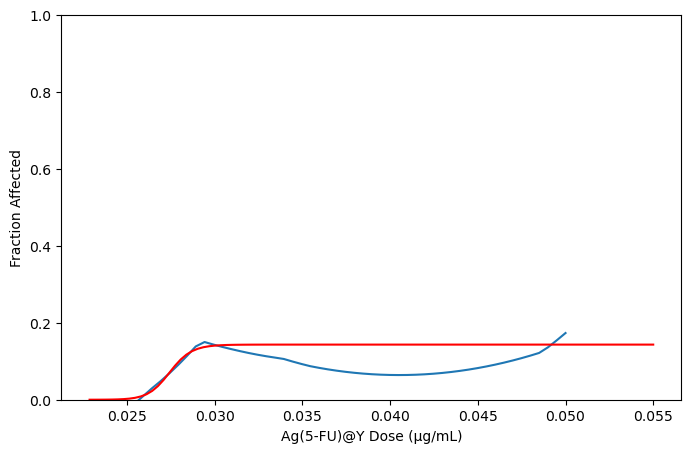

In [19]:
# Dose - Response Curve for Ag(5-FU)@Y

npoints=50
dose_min=0.0254#data['Ag(5-FU)@Y'].min()
dose_max=data['Ag(5-FU)@Y'].max()
dose=np.linspace(dose_min,dose_max,npoints)

X_data = pd.DataFrame({'AgY':np.zeros(npoints),
                       '5-FU@Y':np.zeros(npoints),
                       'Ag(5-FU)@Y':dose})
fraction_afected = 1.0-(s_model.predict(X_data)/100.0)

print(f"Dose (µg/mL) {'Fraction Affected':^20s}")
for i, d in enumerate(dose):
    print(f"{d:8.4f}  {fraction_afected[i]:^20.4f}")

opt = optimize.curve_fit(dr_curve,dose[:12],fraction_afected[:12],bounds=(0,[1.0,dose_max,np.inf]))

E_max_AFUY, EC50_AFUY, n_AFUY =opt[0]

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(dose,fraction_afected)
plt.plot(np.linspace(0.9*dose_min,1.1*dose_max,npoints*2),dr_curve(np.linspace(0.9*dose_min,1.1*dose_max,npoints*2),E_max_AFUY,EC50_AFUY,n_AFUY),c="red")
ax.set_xlabel("Ag(5-FU)@Y Dose (µg/mL)")
ax.set_ylabel("Fraction Affected")
ax.set_ylim(0,1)

print(f"Dose-Response Parameters for Ag(5-FU)@Y: n= {n_AFUY:6.4f}, D50= {EC50_AFUY:6.4f} µg/mL, EC_Max= {E_max_AFUY:6.4f}")

Clearly, Ag(5-FU)@Y does not follow a traditional dose-response behaviour.

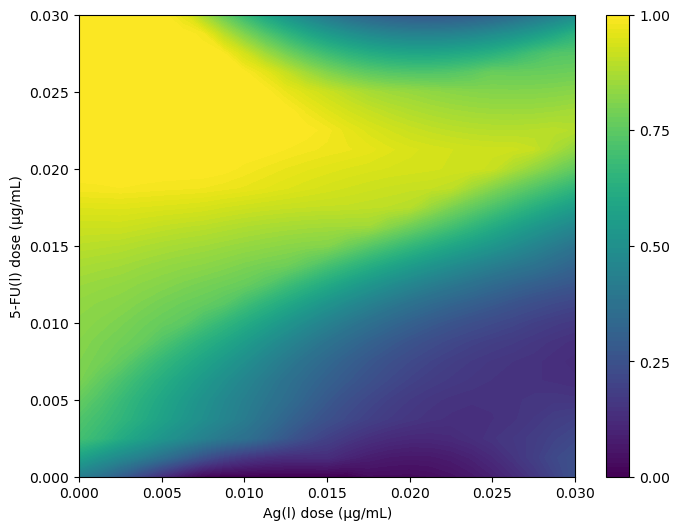

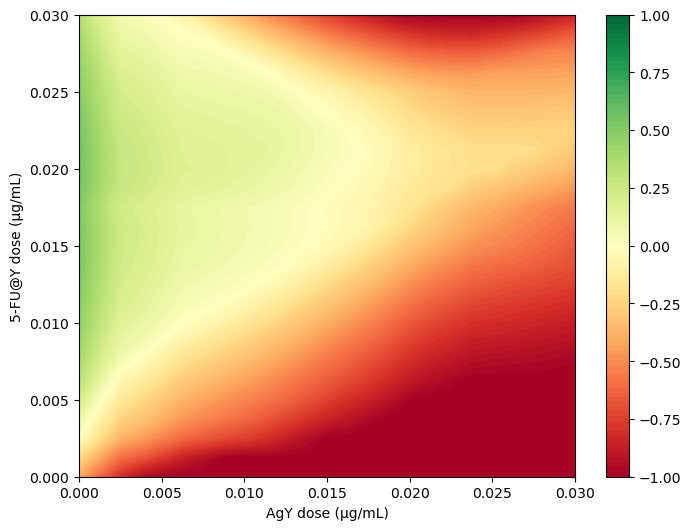

In [20]:
# bi-dimensional Dose-Response curve for AgY and 5-FU@Y
npoints = 25
ag_min=s_data['AgY'].min()
ag_max=0.03#s_data['AgY'].max()
fu_min=s_data['5-FU@Y'].min()
fu_max=0.03#s_data['5-FU@Y'].max()
dose_ag = np.linspace(ag_min,ag_max,npoints)
dose_fu = np.linspace(fu_min,fu_max,npoints)

X_data = pd.DataFrame({'AgY':dose_ag,
                       '5-FU@Y':np.zeros(npoints),
                       'Ag(5-FU)@Y':np.zeros(npoints)
                      })
fraction_afected_ag = 1.0-(s_model.predict(X_data)/100.0)

X_data = pd.DataFrame({'AgY':np.zeros(npoints),
                       '5-FU@Y':dose_fu,
                       'Ag(5-FU)@Y':np.zeros(npoints)
                      })
fraction_afected_fu = 1.0-(s_model.predict(X_data)/100.0)


X_d={'AgY':list(),'5-FU@Y':list(),'Ag(5-FU)@Y':list()}
for i in dose_ag:
    for j in dose_fu:
        X_d['AgY'].append(i)
        X_d['5-FU@Y'].append(j)
        X_d['Ag(5-FU)@Y'].append(0.0)

response = 1.0-(s_model.predict(pd.DataFrame(X_d))/100.0)


z=np.zeros((npoints,npoints))
diff = np.zeros((npoints,npoints))
CI = np.zeros((npoints,npoints))

for i,d_agl in enumerate(dose_ag):
    for j,d_5ful in enumerate(dose_fu):
        z[i,j]=response[i+(npoints*j)]
        if z[i,j]<0.0: z[i,j]=0.0
        if z[i,j]>1.0: z[i,j]=1.0
        diff[i,j] = z[i,j] - (fraction_afected_ag[i]+fraction_afected_fu[j])

diff[diff>1.0]=1.0
diff[diff< -1.0]=-1.0

fig, ax = plt.subplots(figsize=(8,6))
cp = ax.contourf(dose_ag,dose_fu,z, levels=np.linspace(0.0,1.0,100))
ax.set_ylim(fu_min,fu_max)
ax.set_xlim(ag_min,ag_max)
cb = fig.colorbar(cp)
cb.set_ticks([0.0,0.25,0.5,0.75,1.0])
ax.set_xlabel("Ag(l) dose (µg/mL)")
ax.set_ylabel("5-FU(l) dose (µg/mL)")
plt.show()

fig, ax = plt.subplots(figsize=(8,6))
cp = ax.contourf(dose_ag,dose_fu,diff, levels=np.linspace(-1.0,1.0,100), cmap="RdYlGn")
ax.set_ylim(fu_min,fu_max)
ax.set_xlim(ag_min,ag_max)
cb = fig.colorbar(cp)
cb.set_ticks([-1.0,-0.75,-0.5,-0.25,0.0,0.25,0.5,0.75,1.0])
ax.set_xlabel("AgY dose (µg/mL)")
ax.set_ylabel("5-FU@Y dose (µg/mL)")
plt.show()

### Calculation of IC50

In [21]:
IC50_Agl = idr_curve(0.5,E_max_Agl,EC50_Agl,n_Agl)
IC50_FUl = idr_curve(0.5,E_max_FUl,EC50_FUl,n_FUl)
IC50_AgY = idr_curve(0.5,E_max_AgY,EC50_AgY,n_AgY)
IC50_FUY = idr_curve(0.5,E_max_FUY,EC50_FUY,n_FUY)

print(f"{'System':^10s} {'IC50':^10s}")
print(f"{'':^10s} {'(µg/mL)':^10s}")
print(f"{'Ag(l)':^10s} {IC50_Agl:^10.4f}")
print(f"{'5-FU(l)':^10s} {IC50_FUl:^10.4f}")
print(f"{'AgY':^10s} {IC50_AgY:^10.4f}")
print(f"{'5-FU@Y':^10s} {IC50_FUY:^10.4f}")


  System      IC50   
            (µg/mL)  
  Ag(l)      0.7200  
 5-FU(l)     1.2966  
   AgY       0.0453  
  5-FU@Y     0.0003  


## Figures For Main Text

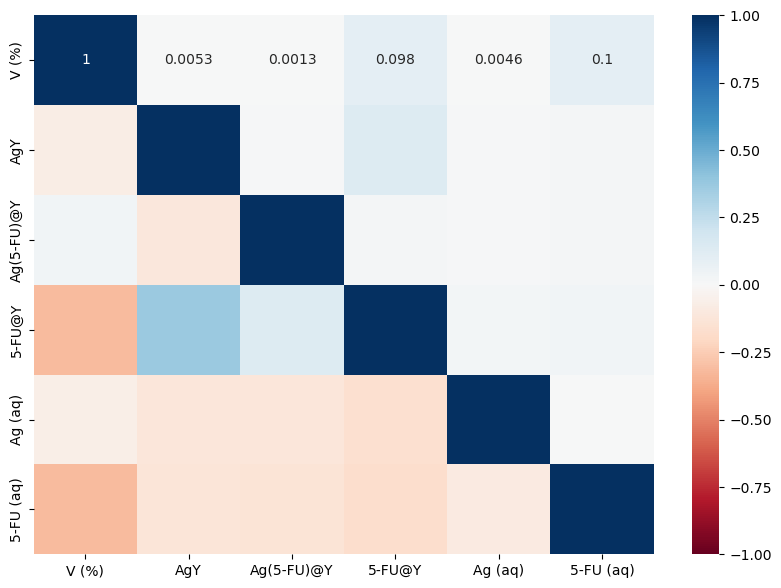

In [22]:
#Heatmap figure for main text
all_vars = [target] + s_features + l_features
r=data[all_vars].corr()
rsq=data[all_vars].corr()**2
for i in range(len(all_vars)):
    for j in range(i,len(all_vars)):
        r.iloc[i,j]=rsq.iloc[i,j]
fig,ax = plt.subplots(1,1,figsize=(10,7))
dataplot = sb.heatmap(r, vmin=-1.0, vmax=1.0, cmap="RdBu", annot=True, ax=ax,
                     xticklabels=['V (%)', 'AgY', 'Ag(5-FU)@Y', '5-FU@Y', 'Ag (aq)', '5-FU (aq)'],
                     yticklabels=['V (%)', 'AgY', 'Ag(5-FU)@Y', '5-FU@Y', 'Ag (aq)', '5-FU (aq)'],
                     )
plt.savefig("fig_heatmap.png", dpi=120)

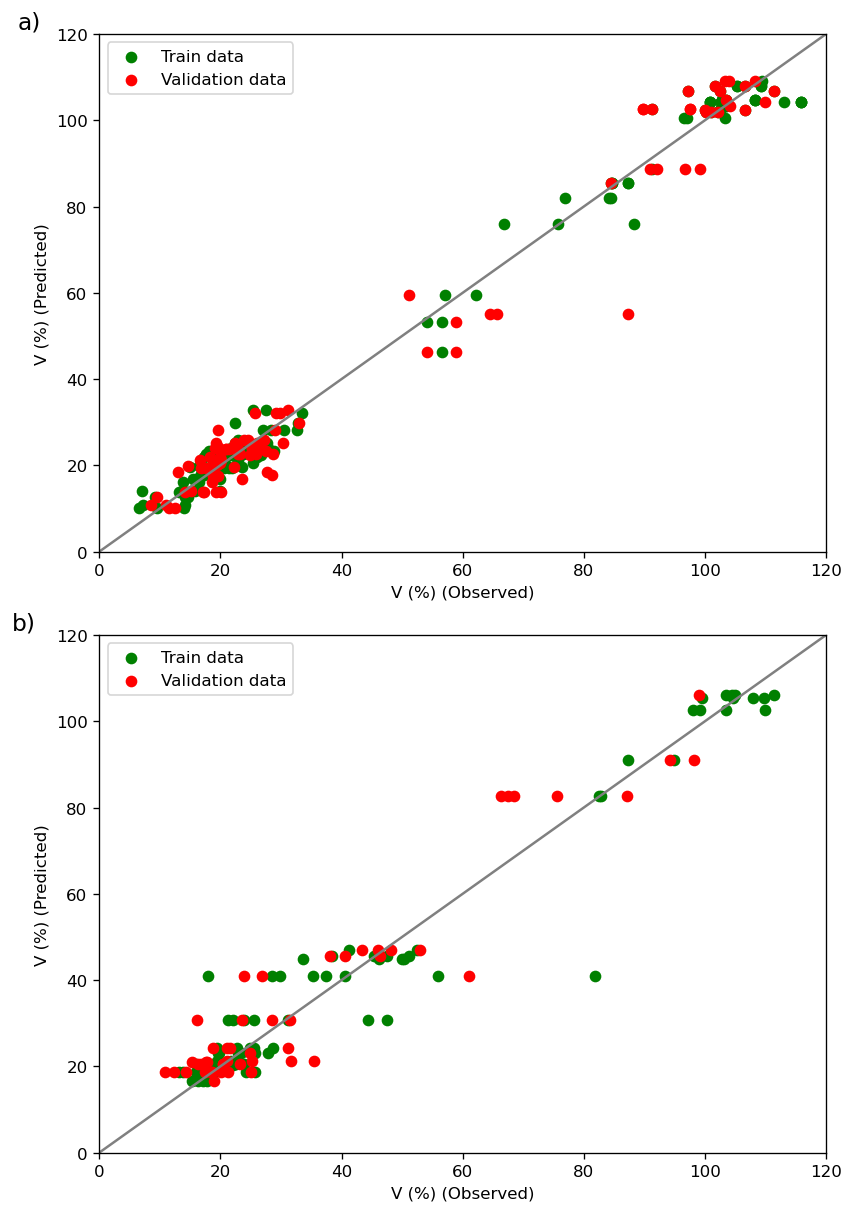

In [23]:
# Fitness Plots for main text

def make_fitness_plot(model, x_train, y_train, x_test, y_test, y_name='Property', ax=None):
  y_train_pred = model.predict(x_train)
  y_test_pred = model.predict(x_test)
  if not ax:
    fig, ax = plt.subplots()
  l_train = ax.scatter(y_train,y_train_pred,c='green')
  l_test = ax.scatter(y_test,y_test_pred,c='red')
  l3 = ax.plot(np.linspace(x_min,x_max,10),np.linspace(x_min,x_max,10),c='grey')
  ax.set_xlabel(f"{y_name} (Observed)")
  ax.set_ylabel(f"{y_name} (Predicted)")
  l = ax.legend([l_train,l_test],['Train data','Validation data'])

y_min=0
y_max=120
x_min=0
x_max=120
dpi=120
fig, axs = plt.subplots(2,1,figsize=(7,10),dpi=dpi, layout='constrained')
axs[0].text(x_min-(0.08*(x_max-x_min)),y_max,'a)', fontsize=14, va='bottom', ha='right')
make_fitness_plot(l_model,l_X_train,l_Y_train,l_X_val,l_Y_val,'V (%)',ax=axs[0])
axs[0].set_xlim(x_min,x_max)
axs[0].set_ylim(y_min,y_max)
axs[1].text(x_min-(0.12*(x_max-x_min)),y_max,'b)', fontsize=14, va='bottom', ha='left')
make_fitness_plot(s_model,s_X_train,s_Y_train,s_X_val,s_Y_val,'V (%)',ax=axs[1])
axs[1].set_xlim(x_min,x_max)
axs[1].set_ylim(y_min,y_max)
plt.savefig('fitness_plots.png',dpi=dpi)

/tmp/ipykernel_53530/2656640208.py:4: RuntimeWarning: divide by zero encountered in divide
  return E_max/(1+((EC50/dose)**n))
/tmp/ipykernel_53530/2656640208.py:4: RuntimeWarning: divide by zero encountered in divide
  return E_max/(1+((EC50/dose)**n))
/tmp/ipykernel_53530/2656640208.py:4: RuntimeWarning: divide by zero encountered in divide
  return E_max/(1+((EC50/dose)**n))
/tmp/ipykernel_53530/2656640208.py:4: RuntimeWarning: divide by zero encountered in divide
  return E_max/(1+((EC50/dose)**n))


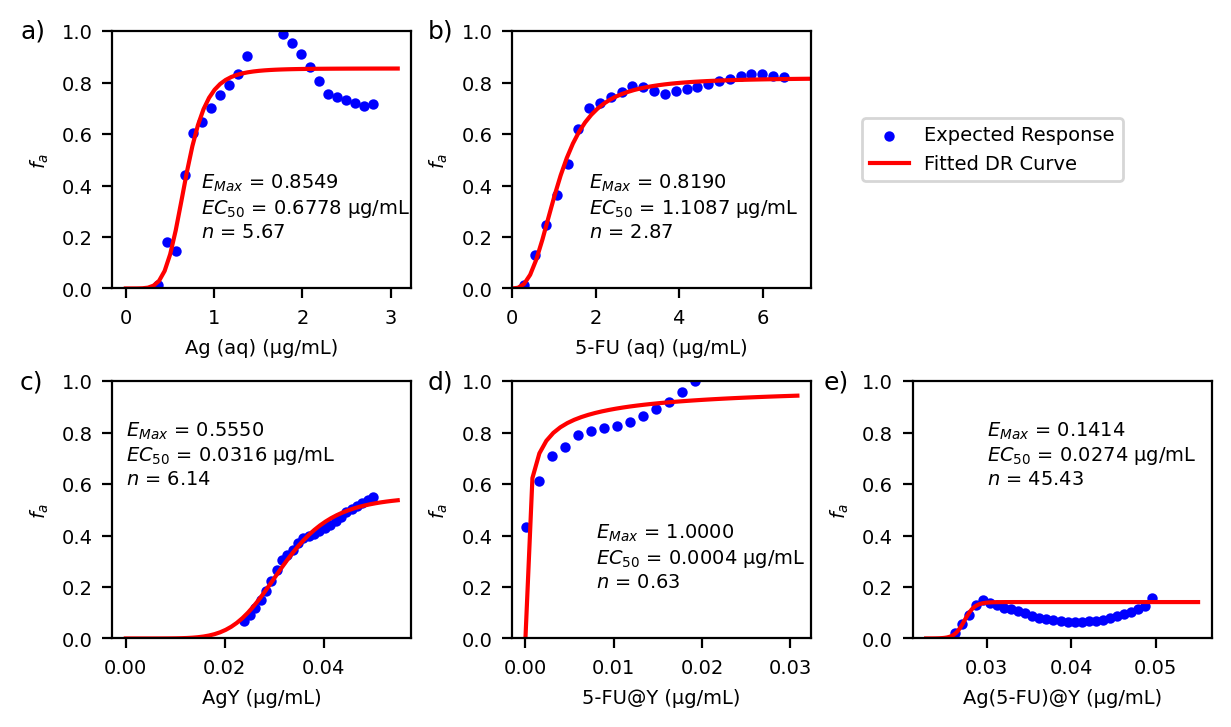

In [24]:
# Dose-Response Curves


dpi=200
plt.rc('font', size=7)

fig = plt.figure(figsize=(6,3.5), dpi=dpi, layout='constrained')
gs=fig.add_gridspec(nrows=2, ncols=3)

axs=list()
axs.append(fig.add_subplot(gs[0,0]))
axs.append(fig.add_subplot(gs[0,1],xmargin=0.0))
axs.append(fig.add_subplot(gs[1,0]))
axs.append(fig.add_subplot(gs[1,1]))
axs.append(fig.add_subplot(gs[1,2]))


# Dose - Response Curve for Ag_l
npoints=25
dose_min=0.36
dose_max=2.8
dose=np.linspace(dose_min,dose_max,npoints)
X_data = pd.DataFrame({'Ag_l':dose,
                       'FU_l':np.zeros(npoints)})
fraction_afected = 1.0-(l_model.predict(X_data)/100.0) 
opt = optimize.curve_fit(dr_curve,dose,fraction_afected,bounds=(0,np.inf))
E_max_Agl, EC50_Agl, n_Agl =opt[0]
plt_x=np.linspace(0,1.1*dose_max,npoints*2)
axs[0].scatter(dose,fraction_afected, c='blue',s=7.5)
axs[0].plot(plt_x,dr_curve(plt_x,E_max_Agl,EC50_Agl,n_Agl),c="red")
axs[0].set_xlabel("Ag (aq) (µg/mL)")
axs[0].set_ylabel(r"$f_a$")
text=f"$E_{{Max}}$ = {E_max_Agl:0.4f}\n$EC_{{50}}$ = {EC50_Agl:0.4f} µg/mL\n$n$ = {n_Agl:0.2f}"
axs[0].text(0.85,0.2,text)
axs[0].set_ylim(0,1)


# Dose - Response Curve for 5-FU (l)
npoints=25
dose_min=0.3 #data['FU_l'].min()
dose_max=6.5 #data['FU_l'].max()
dose=np.linspace(dose_min,dose_max,npoints)
X_data = pd.DataFrame({'FU_l':dose,
                       'Ag_l':np.zeros(npoints)})
fraction_afected = 1.0-(l_model.predict(X_data)/100.0)
opt = optimize.curve_fit(dr_curve,dose,fraction_afected,bounds=(0,np.inf))
E_max_FUl, EC50_FUl, n_FUl =opt[0]
plt_x=np.linspace(0,1.1*dose_max,npoints*2)
axs[1].scatter(dose,fraction_afected, c='blue',s=7.5)
axs[1].plot(plt_x,dr_curve(plt_x,E_max_FUl,EC50_FUl,n_FUl),c="red")
axs[1].set_xlabel("5-FU (aq) (µg/mL)")
axs[1].set_ylabel(r"$f_a$")
text=f"$E_{{Max}}$ = {E_max_FUl:0.4f}\n$EC_{{50}}$ = {EC50_FUl:0.4f} µg/mL\n$n$ = {n_FUl:0.2f}"
axs[1].text(1.85,0.2,text)
axs[1].set_ylim(0,1)

# Dose - Response Curve for AgY
npoints=25
dose_min=0.024
dose_max=data['AgY'].max()
dose=np.linspace(dose_min,dose_max,npoints)
X_data = pd.DataFrame({'AgY':dose,
                       '5-FU@Y':np.zeros(npoints),
                       'Ag(5-FU)@Y':np.zeros(npoints)})
fraction_afected = 1.0-(s_model.predict(X_data)/100.0)
opt = optimize.curve_fit(dr_curve,dose,fraction_afected,bounds=(0,np.inf))
E_max_AgY, EC50_AgY, n_AgY =opt[0]
plt_x=np.linspace(0,1.1*dose_max,npoints*2)
f_pts=axs[2].scatter(dose,fraction_afected,c='blue',s=7.5)
f_lns=axs[2].plot(plt_x,dr_curve(plt_x,E_max_AgY,EC50_AgY,n_AgY),c="red")
axs[2].set_xlabel("AgY (µg/mL)")
axs[2].set_ylabel(r"$f_a$")
text=f"$E_{{Max}}$ = {E_max_AgY:0.4f}\n$EC_{{50}}$ = {EC50_AgY:0.4f} µg/mL\n$n$ = {n_AgY:0.2f}"
axs[2].text(0.0,0.6,text)
axs[2].set_ylim(0,1)

# Dose - Response Curve for 5-FU@Y
npoints=20
dose_min=0.0001#data['5-FU@Y'].min()
dose_max=0.028#data['5-FU@Y'].max()
dose=np.linspace(dose_min,dose_max,npoints)
X_data = pd.DataFrame({'AgY':np.zeros(npoints),
                       '5-FU@Y':dose,
                       'Ag(5-FU)@Y':np.zeros(npoints)})
fraction_afected = 1.0-(s_model.predict(X_data)/100.0)
opt = optimize.curve_fit(dr_curve,dose,fraction_afected,bounds=(0,[1.0,dose_max,np.inf]))
E_max_FUY, EC50_FUY, n_FUY =opt[0]
plt_x=np.linspace(0,1.1*dose_max,npoints*2)
axs[3].scatter(dose,fraction_afected,c='blue',s=7.5)
axs[3].plot(plt_x,dr_curve(plt_x,E_max_FUY,EC50_FUY,n_FUY),c="red")
axs[3].set_xlabel("5-FU@Y (µg/mL)")
axs[3].set_ylabel(r"$f_a$")
text=f"$E_{{Max}}$ = {E_max_FUY:0.4f}\n$EC_{{50}}$ = {EC50_FUY:0.4f} µg/mL\n$n$ = {n_FUY:0.2f}"
axs[3].text(0.008,0.2,text)
axs[3].set_ylim(0,1)


# Dose - Response Curve for Ag(5-FU)@Y
npoints=60
dose_min=0.0254#data['Ag(5-FU)@Y'].min()
dose_max=data['Ag(5-FU)@Y'].max()
dose=np.linspace(dose_min,dose_max,npoints)
X_data = pd.DataFrame({'AgY':np.zeros(npoints),
                       '5-FU@Y':np.zeros(npoints),
                       'Ag(5-FU)@Y':dose})
fraction_afected = 1.0-(s_model.predict(X_data)/100.0)
opt = optimize.curve_fit(dr_curve,dose[:15],fraction_afected[:15],bounds=(0,[1.0,dose_max,np.inf]))
E_max_AFUY, EC50_AFUY, n_AFUY =opt[0]
plt_x=np.linspace(0,1.1*dose_max,npoints*2)
axs[4].scatter(dose[::2],fraction_afected[::2],c='blue',s=7.5)
axs[4].plot(np.linspace(0.9*dose_min,1.1*dose_max,npoints*2),dr_curve(np.linspace(0.9*dose_min,1.1*dose_max,npoints*2),E_max_AFUY,EC50_AFUY,n_AFUY),c="red")
axs[4].set_xlabel("Ag(5-FU)@Y (µg/mL)")
axs[4].set_ylabel(r"$f_a$")
text=f"$E_{{Max}}$ = {E_max_AFUY:0.4f}\n$EC_{{50}}$ = {EC50_AFUY:0.4f} µg/mL\n$n$ = {n_AFUY:0.2f}"
axs[4].text(0.03,0.6,text)
axs[4].set_ylim(0,1)

fig.legend([f_pts,f_lns[0]],['Expected Response','Fitted DR Curve'], loc=(0.70,0.75))

fig.text(0.0,0.96,'a)', fontsize=9, va='bottom', ha='left')
fig.text(0.34,0.96,'b)',fontsize=9, va='bottom', ha='left')
fig.text(0.0,0.46,'c)', fontsize=9, va='bottom', ha='left')
fig.text(0.34,0.46,'d)',fontsize=9, va='bottom', ha='left')
fig.text(0.67,0.46,'e)',fontsize=9, va='bottom', ha='left')

plt.savefig('dr_curve_plots.png',dpi=dpi)

/tmp/ipykernel_53530/2656640208.py:7: RuntimeWarning: invalid value encountered in scalar power
  return EC50/(E_max/effect-1)**(1/n)
/tmp/ipykernel_53530/2656640208.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  return EC50/(E_max/effect-1)**(1/n)


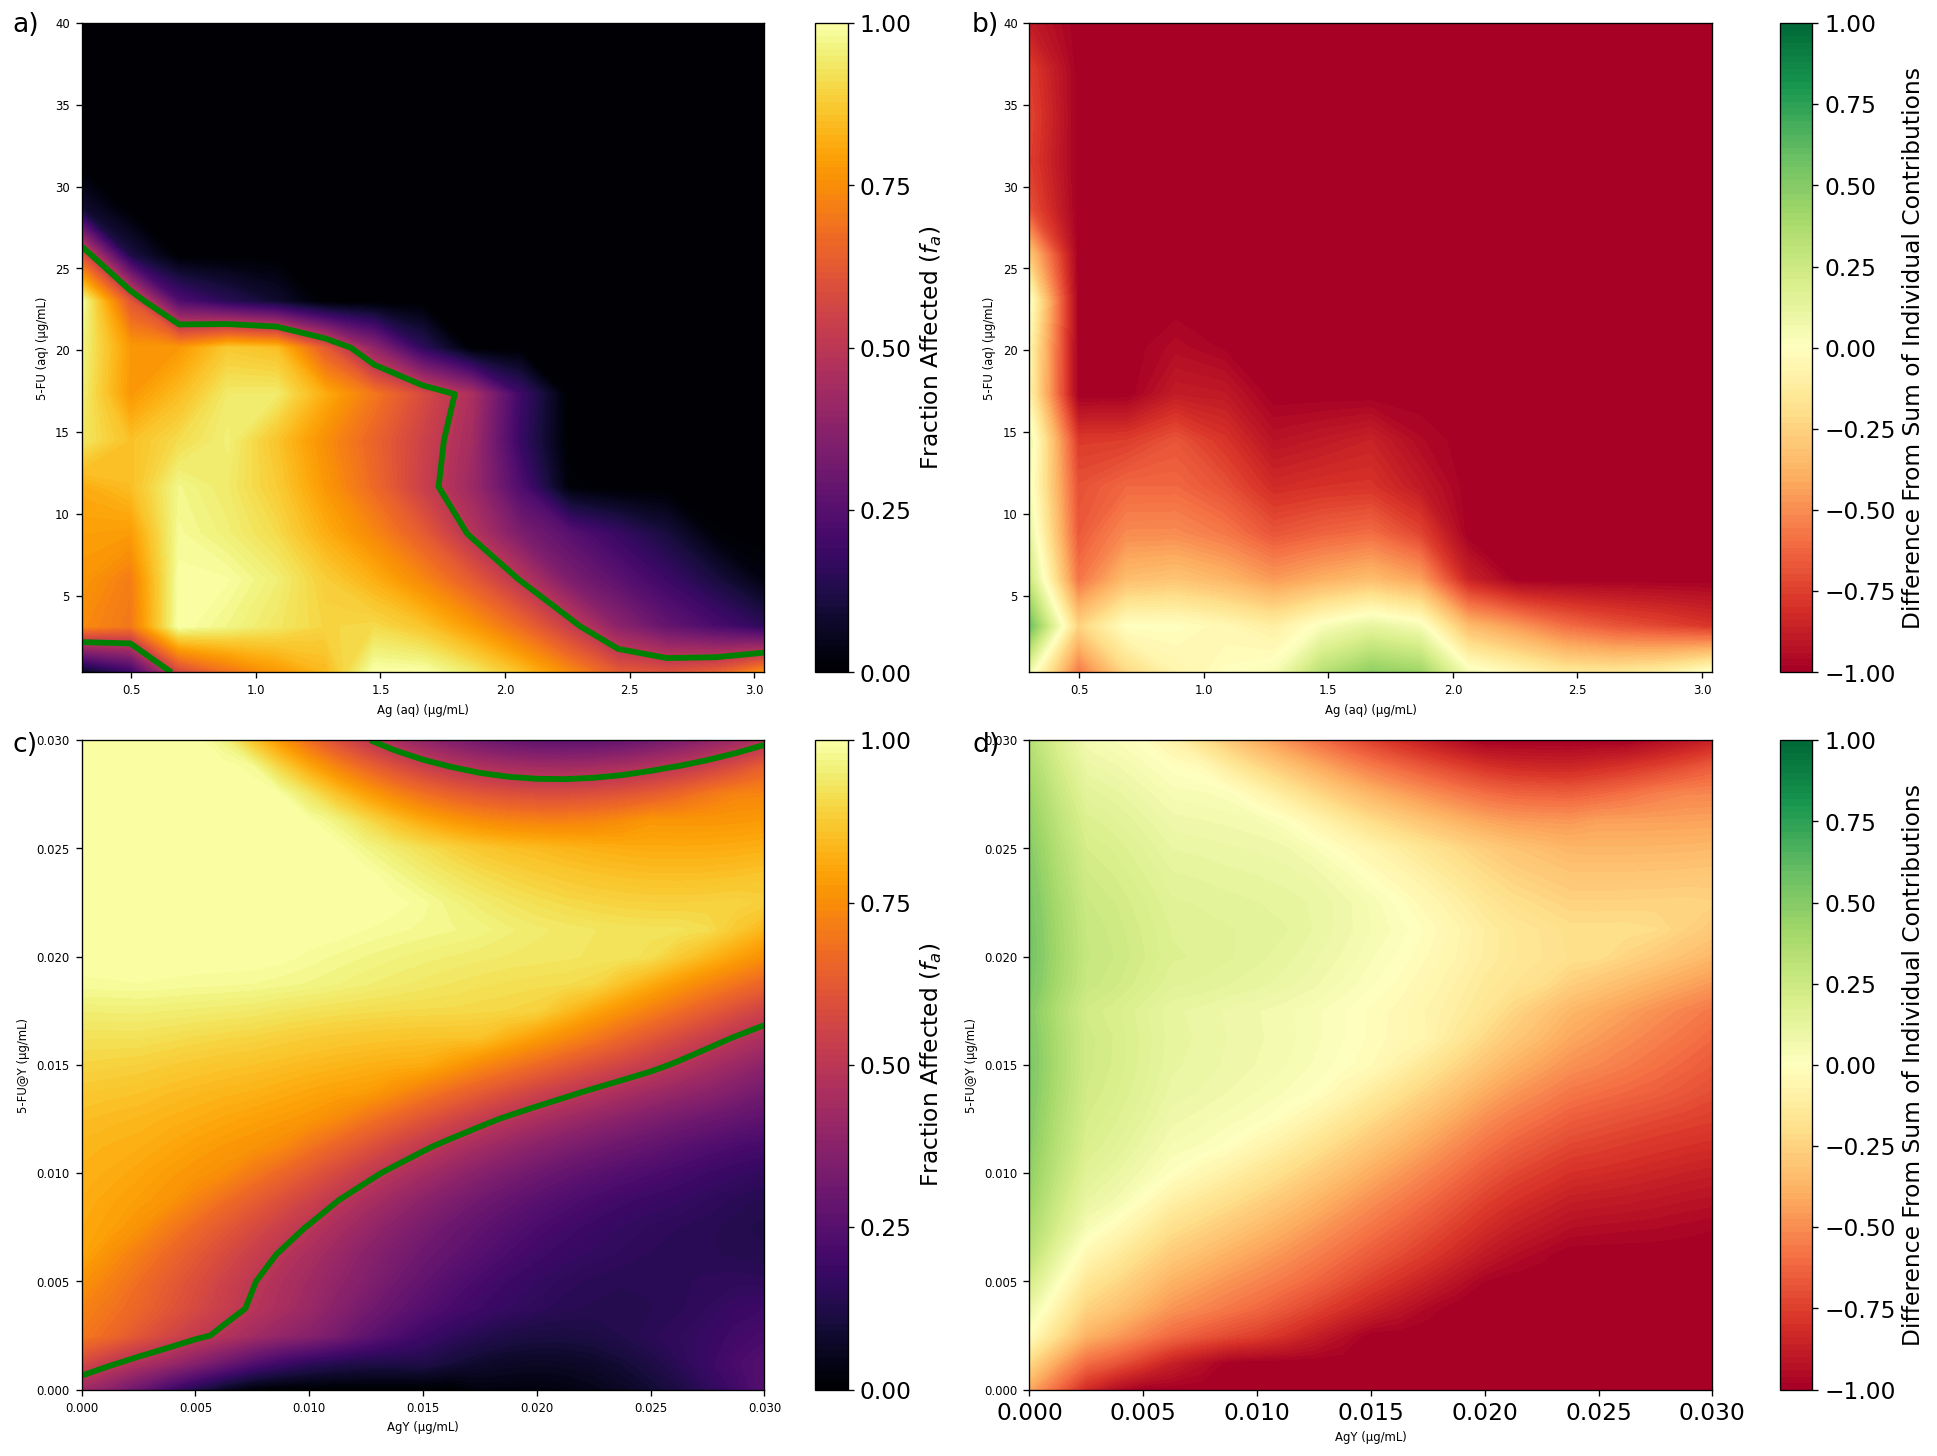

In [25]:
# Bi-component DR surfaces

dpi=120
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(16,12), dpi=dpi, layout='constrained')

plt.rc('font', size=14)
plt.xticks(fontsize=14)

# bi-dimensional Dose-Response curve for Ag(l) and 5-FU(l)
npoints = 15
ag_min=0.3
ag_max=data['Ag_l'].max()
fu_min=0.3
fu_max=40.0 #data['FU_l'].max()
dose_ag = np.linspace(ag_min,ag_max,npoints)
dose_fu = np.linspace(fu_min,fu_max,npoints)
X_data = pd.DataFrame({'Ag_l':dose_ag,
                       'FU_l':np.zeros(npoints)})
fraction_afected_ag = 1.0-(l_model.predict(X_data)/100.0)
X_data = pd.DataFrame({'Ag_l':np.zeros(npoints),
                       'FU_l':dose_fu})
fraction_afected_fu = 1.0-(l_model.predict(X_data)/100.0)
X_d={'Ag_l':list(),'FU_l':list()}
for i in dose_ag:
    for j in dose_fu:
        X_d['Ag_l'].append(i)
        X_d['FU_l'].append(j)
response = 1.0-(l_model.predict(pd.DataFrame(X_d))/100.0)
z=np.zeros((npoints,npoints))
diff = np.zeros((npoints,npoints))
for i,d_agl in enumerate(dose_ag):
    for j,d_5ful in enumerate(dose_fu):
        z[i,j]=response[i+(npoints*j)]
        if z[i,j]<0.0: z[i,j]=0.0
        if z[i,j]>1.0: z[i,j]=1.0
        frac_ag=d_agl/(d_agl+d_5ful)
        frac_fu=d_5ful/(d_agl+d_5ful)
        eq_agl = idr_curve(frac_ag*z[i,j],E_max_Agl,EC50_Agl,n_Agl)
        eq_5ful = idr_curve(frac_fu*z[i,j],E_max_FUl,EC50_FUl,n_FUl)
        diff[i,j] = z[i,j] - (fraction_afected_ag[i]+fraction_afected_fu[j])
diff[diff>1.0]=1.0
diff[diff< -1.0]=-1.0

cp = axs[0,0].contourf(dose_ag,dose_fu,z, levels=np.linspace(0.0,1.0,100), cmap='inferno')
cp2 = axs[0,0].contour(dose_ag,dose_fu,z, levels=[0.5], colors='green',linewidths=3.5 )
axs[0,0].set_ylim(fu_min,fu_max)
axs[0,0].set_xlim(ag_min,ag_max)
cb = fig.colorbar(cp, ax=axs[0,0], label=r"Fraction Affected ($f_a$)")
cb.set_ticks([0.0,0.25,0.5,0.75,1.0])
axs[0,0].set_xlabel("Ag (aq) (µg/mL)")
axs[0,0].set_ylabel("5-FU (aq) (µg/mL)")

cp = axs[0,1].contourf(dose_ag,dose_fu,diff, levels=np.linspace(-1.0,1.0,100), cmap="RdYlGn")
axs[0,1].set_ylim(fu_min,fu_max)
axs[0,1].set_xlim(ag_min,ag_max)
cb = fig.colorbar(cp, ax=axs[0,1], label= "Difference From Sum of Individual Contributions")
cb.set_ticks([-1.0,-0.75,-0.5,-0.25,0.0,0.25,0.5,0.75,1.0])
axs[0,1].set_xlabel("Ag (aq) (µg/mL)")
axs[0,1].set_ylabel("5-FU (aq) (µg/mL)")

# bi-dimensional Dose-Response curve for AgY and 5-FU@Y
npoints = 25
ag_min=s_data['AgY'].min()
ag_max=0.03#s_data['AgY'].max()
fu_min=s_data['5-FU@Y'].min()
fu_max=0.03#s_data['5-FU@Y'].max()
dose_ag = np.linspace(ag_min,ag_max,npoints)
dose_fu = np.linspace(fu_min,fu_max,npoints)
X_data = pd.DataFrame({'AgY':dose_ag,
                       '5-FU@Y':np.zeros(npoints),
                       'Ag(5-FU)@Y':np.zeros(npoints)
                      })
fraction_afected_ag = 1.0-(s_model.predict(X_data)/100.0)
X_data = pd.DataFrame({'AgY':np.zeros(npoints),
                       '5-FU@Y':dose_fu,
                       'Ag(5-FU)@Y':np.zeros(npoints)
                      })
fraction_afected_fu = 1.0-(s_model.predict(X_data)/100.0)
X_d={'AgY':list(),'5-FU@Y':list(),'Ag(5-FU)@Y':list()}
for i in dose_ag:
    for j in dose_fu:
        X_d['AgY'].append(i)
        X_d['5-FU@Y'].append(j)
        X_d['Ag(5-FU)@Y'].append(0.0)
response = 1.0-(s_model.predict(pd.DataFrame(X_d))/100.0)
z=np.zeros((npoints,npoints))
diff = np.zeros((npoints,npoints))
for i,d_agl in enumerate(dose_ag):
    for j,d_5ful in enumerate(dose_fu):
        z[i,j]=response[i+(npoints*j)]
        if z[i,j]<0.0: z[i,j]=0.0
        if z[i,j]>1.0: z[i,j]=1.0
        diff[i,j] = z[i,j] - (fraction_afected_ag[i]+fraction_afected_fu[j])
diff[diff>1.0]=1.0
diff[diff< -1.0]=-1.0
cp = axs[1,0].contourf(dose_ag,dose_fu,z, levels=np.linspace(0.0,1.0,100), cmap='inferno')
cp2 = axs[1,0].contour(dose_ag,dose_fu,z, levels=[0.5], colors='green',linewidths=3.5 )
axs[1,0].set_ylim(fu_min,fu_max)
axs[1,0].set_xlim(ag_min,ag_max)
cb = fig.colorbar(cp, ax=axs[1,0], label=r"Fraction Affected ($f_a$)")
cb.set_ticks([0.0,0.25,0.5,0.75,1.0])
axs[1,0].set_xlabel("AgY (µg/mL)")
axs[1,0].set_ylabel("5-FU@Y (µg/mL)")

cp = axs[1,1].contourf(dose_ag,dose_fu,diff, levels=np.linspace(-1.0,1.0,100), cmap="RdYlGn")
axs[1,1].set_ylim(fu_min,fu_max)
axs[1,1].set_xlim(ag_min,ag_max)
cb = fig.colorbar(cp, ax=axs[1,1], label= "Difference From Sum of Individual Contributions")
cb.set_ticks([-1.0,-0.75,-0.5,-0.25,0.0,0.25,0.5,0.75,1.0])
axs[1,1].set_xlabel("AgY (µg/mL)")
axs[1,1].set_ylabel("5-FU@Y (µg/mL)")

fig.text(0.0,0.98,'a)',fontsize=16, va='bottom', ha='left')
fig.text(0.5,0.98,'b)',fontsize=16, va='bottom', ha='left')
fig.text(0.0,0.48,'c)',fontsize=16, va='bottom', ha='left')
fig.text(0.5,0.48,'d)',fontsize=16, va='bottom', ha='left')


plt.savefig('dr_surface_plots.png',dpi=dpi)